In [10]:
from dotenv import load_dotenv

_ = load_dotenv()

In [11]:
from langchain import hub
from langchain.agents import create_openai_functions_agent
from langchain_openai.chat_models import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode


In [12]:
from pydantic import BaseModel, Field

class SearchType(BaseModel):
    """Look up things online and optionally returning directly"""
    query: str = Field(description="query to look up online")
    return_direct: bool = Field(
        description="Whether or not the result of this should be returned directly to the user without you seeing what it is",
        default=False
    )

class Response(BaseModel):
    """Final Response to the user"""
    temperature: float = Field(description="the temperature")
    other_notes: str = Field(description="any other notes about the weather")
    

In [20]:
tools = [TavilySearchResults(max_results=1, args_schema=SearchType)]
tool_node = ToolNode(tools)
tools_by_name = {tool.name: tool for tool in tools}

In [21]:
model = ChatOpenAI( temperature=0, streaming=True)

In [22]:
# from langchain_core.utils.function_calling import convert_to_openai_function
# functions = [convert_to_openai_function(t) for t in tools]

model = model.bind_tools(tools)

In [23]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage, ToolMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [24]:
from langgraph.prebuilt import ToolInvocation
import json
from langchain_core.messages import FunctionMessage

In [28]:
from langgraph.types import Command

def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)
    if isinstance(last_message, Response):
        return 'end'
    elif last_message.tool_calls:
        if 'return_direct' in last_message.tool_calls[0]['args']:
            return "final"
        return "continue"
    return "end"

def call_model(state):
    messages = state['messages']
    response = model.invoke(messages)
    
    return {"messages": [response]}

def call_tool(state):
    messages = state["messages"]
    del messages[-1].tool_calls[0]['args']['return_direct']
    response = tool_node.invoke({"messages": messages})
    return {"messages" : [response]}
    

def tool_node(state):
    result = []
    for tool_call in state["messages"][-1].tool_calls:
      
        tool = tools_by_name[tool_call["name"]]
        if tool_call['name']=="tavily_search_results_json":
            if 'return_direct' in tool_call['args']:
                del tool_call['args']['return_direct']
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=json.dumps(observation), tool_call_id=tool_call["id"]))
    return {"messages": result}




    


In [29]:
from langgraph.graph import StateGraph, END
workflow = StateGraph(AgentState)

workflow.add_node("llm", call_model)
workflow.add_node("tools", tool_node)
workflow.add_node("final", tool_node)

workflow.set_entry_point("llm")

workflow.add_conditional_edges(
    "llm",
    should_continue,
    {
        "continue":"tools",
        "final": "final",
        "end": END
    }
)

workflow.add_edge("tools", "llm")
workflow.add_edge("final", END)

app = workflow.compile()

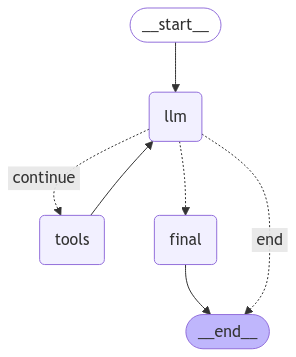

In [30]:
app

In [31]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="search for what is weather in toronto, on?")]}
for chunk in app.stream(inputs):
    for key, value in chunk.items():
        print("Output from node '{}' :".format(key))
        print("-----------")
        print(value)
    print("\n-------------\n")

content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_yzvwHTwZmYXqeH9cvf7nKDWX', 'function': {'arguments': '{"query":"weather in Toronto, ON"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-3.5-turbo-0125'} id='run-5c04f283-a35a-4ff6-b8af-2c5a4577b5c7-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Toronto, ON'}, 'id': 'call_yzvwHTwZmYXqeH9cvf7nKDWX', 'type': 'tool_call'}]
Output from node 'llm' :
-----------
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_yzvwHTwZmYXqeH9cvf7nKDWX', 'function': {'arguments': '{"query":"weather in Toronto, ON"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-5c04f283-a35a-4ff6-b8af-2c5a4577b5c7-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query